# ⚡ Energy Consumption Prediction
### Complete ML + Deep Learning Pipeline
---
**Workflow:**
1. Load & Clean Data
2. Rich EDA (distributions, correlations, time patterns)
3. Feature Engineering
4. ML Models with GridSearchCV Pipelines (Ridge, RF, XGBoost, LightGBM)
5. Deep Learning (LSTM)
6. Leaderboard + Save Best Model
7. Inference

> **Key rule:** All splits are **chronological** — no shuffling, no data leakage.

## 0 · Imports

In [61]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats

# Statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.feature_selection import mutual_info_regression

# Boosting
from xgboost import XGBRegressor
try:
    import lightgbm as lgb
    LGB_AVAILABLE = True
except ImportError:
    LGB_AVAILABLE = False
    print('LightGBM not available, skipping')

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import joblib

sns.set_theme(style='whitegrid', palette='pastel')
plt.rcParams.update({'figure.dpi': 100, 'axes.titlesize': 13})
pd.set_option('display.max_columns', None)
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
print(f'✅ TensorFlow {tf.__version__} | Ready')

LightGBM not available, skipping
✅ TensorFlow 2.15.0 | Ready


## 1 · Load & Clean Data

In [62]:
df = pd.read_csv('data\Energy_consumption.csv')

print('Shape:', df.shape)
print('\nColumn types:')
print(df.dtypes)
print('\nMissing values:')
print(df.isnull().sum())
df.head()

Shape: (1000, 11)

Column types:
Timestamp             object
Temperature          float64
Humidity             float64
SquareFootage        float64
Occupancy              int64
HVACUsage             object
LightingUsage         object
RenewableEnergy      float64
DayOfWeek             object
Holiday               object
EnergyConsumption    float64
dtype: object

Missing values:
Timestamp            0
Temperature          0
Humidity             0
SquareFootage        0
Occupancy            0
HVACUsage            0
LightingUsage        0
RenewableEnergy      0
DayOfWeek            0
Holiday              0
EnergyConsumption    0
dtype: int64


,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


In [63]:
# Parse timestamp & sort
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp').reset_index(drop=True)

# Calendar features
df['Hour']      = df['Timestamp'].dt.hour
df['Day']       = df['Timestamp'].dt.day
df['Month']     = df['Timestamp'].dt.month
df['DayOfYear'] = df['Timestamp'].dt.dayofyear
df['WeekOfYear']= df['Timestamp'].dt.isocalendar().week.astype(int)

# Encode categoricals
le = LabelEncoder()
df['HVACUsage']     = le.fit_transform(df['HVACUsage'])      # Off=0, On=1
df['LightingUsage'] = le.fit_transform(df['LightingUsage'])  # Off=0, On=1
df['Holiday']       = le.fit_transform(df['Holiday'])        # No=0, Yes=1

day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df['DayOfWeek'] = pd.Categorical(df['DayOfWeek'], categories=day_order, ordered=True).codes + 1

# Outlier removal (IQR on numeric columns)
num_cols = ['Temperature','Humidity','SquareFootage','Occupancy','RenewableEnergy','EnergyConsumption']
Q1, Q3  = df[num_cols].quantile(0.25), df[num_cols].quantile(0.75)
IQR     = Q3 - Q1
mask    = ((df[num_cols] < (Q1 - 1.5*IQR)) | (df[num_cols] > (Q3 + 1.5*IQR))).any(axis=1)
df      = df[~mask].copy().reset_index(drop=True)

print(f'Shape after cleaning: {df.shape}')
df.describe().round(2)

Shape after cleaning: (999, 16)


,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Hour,Day,Month,DayOfYear,WeekOfYear
count,999,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00
mean,2022-01-21 19:55:51.351351296,24.99,45.39,1499.72,4.58,0.49,0.49,15.14,4.13,0.47,77.08,11.43,13.41,1.26,21.35,5.69
min,2022-01-01 00:00:00,20.01,30.02,1000.51,0.00,0.00,0.00,0.01,1.00,0.00,56.04,0.00,1.00,1.00,1.00,1.00
25%,2022-01-11 10:30:00,22.65,38.29,1246.28,2.00,0.00,0.00,7.62,2.00,0.00,71.55,5.00,6.00,1.00,11.00,2.00
50%,2022-01-21 20:00:00,24.75,45.96,1507.92,5.00,0.00,0.00,15.11,4.00,0.00,76.95,11.00,11.00,1.00,21.00,3.00
75%,2022-02-01 05:30:00,27.42,52.42,1740.13,7.00,1.00,1.00,22.89,6.00,1.00,82.93,17.00,21.00,2.00,32.00,5.00
max,2022-02-11 15:00:00,30.00,59.97,1999.98,9.00,1.00,1.00,29.97,7.00,1.00,99.20,23.00,31.00,2.00,42.00,52.00
std,NaN,2.84,8.52,288.37,2.87,0.50,0.50,8.75,1.98,0.50,8.11,6.91,9.04,0.44,12.03,10.53


## 2 · Exploratory Data Analysis
### 2.1 · Target Distribution

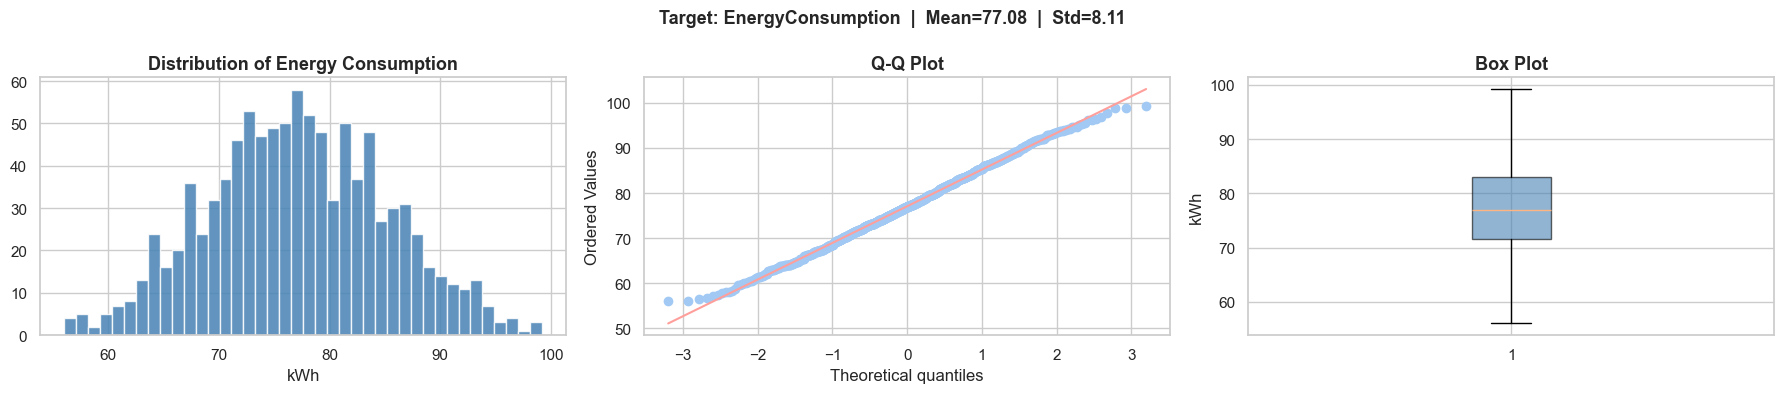

count    999.000
mean      77.080
std        8.113
min       56.038
25%       71.547
50%       76.950
75%       82.933
max       99.201
Name: EnergyConsumption, dtype: float64


In [64]:
TARGET = 'EnergyConsumption'

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].hist(df[TARGET], bins=40, color='steelblue', edgecolor='white', alpha=0.85)
axes[0].set_title('Distribution of Energy Consumption', fontweight='bold')
axes[0].set_xlabel('kWh')

stats.probplot(df[TARGET], plot=axes[1])
axes[1].set_title('Q-Q Plot', fontweight='bold')

axes[2].boxplot(df[TARGET], vert=True, patch_artist=True,
                boxprops=dict(facecolor='steelblue', alpha=0.6))
axes[2].set_title('Box Plot', fontweight='bold')
axes[2].set_ylabel('kWh')

plt.suptitle(f'Target: {TARGET}  |  Mean={df[TARGET].mean():.2f}  |  Std={df[TARGET].std():.2f}',
             fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()
print(df[TARGET].describe().round(3))

### 2.2 · Numeric Feature Distributions

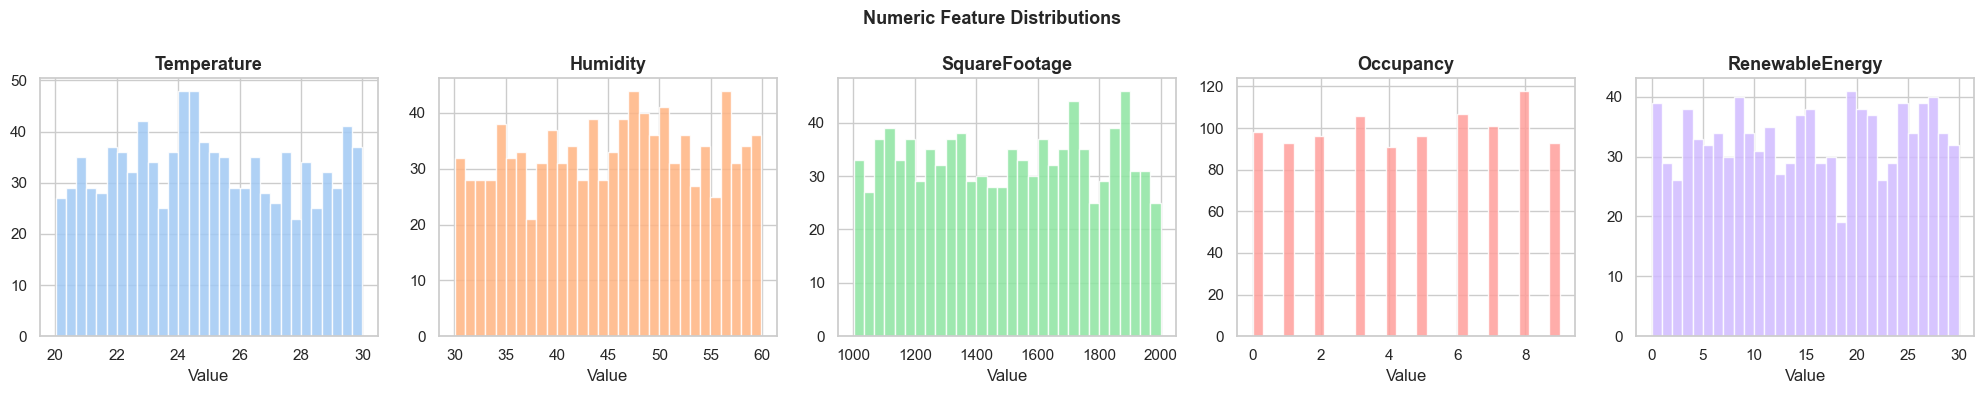

In [65]:
num_feats = ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy']
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for ax, col in zip(axes, num_feats):
    ax.hist(df[col], bins=30, edgecolor='white', alpha=0.85,
            color=sns.color_palette('pastel')[num_feats.index(col)])
    ax.set_title(col, fontweight='bold')
    ax.set_xlabel('Value')
plt.suptitle('Numeric Feature Distributions', fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

### 2.3 · Correlation Heatmap

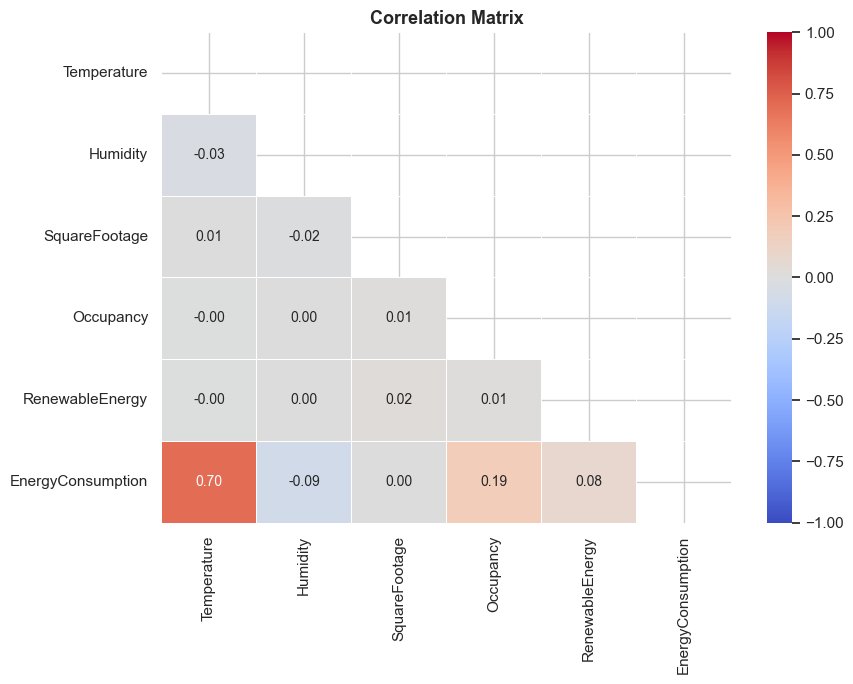

In [66]:
corr_cols = num_feats + [TARGET]
corr = df[corr_cols].corr()

fig, ax = plt.subplots(figsize=(9, 7))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            vmin=-1, vmax=1, ax=ax, linewidths=0.5,
            annot_kws={'size': 10})
ax.set_title('Correlation Matrix', fontweight='bold', fontsize=13)
plt.tight_layout(); plt.show()

### 2.4 · Feature vs Target (Scatter + Regression)

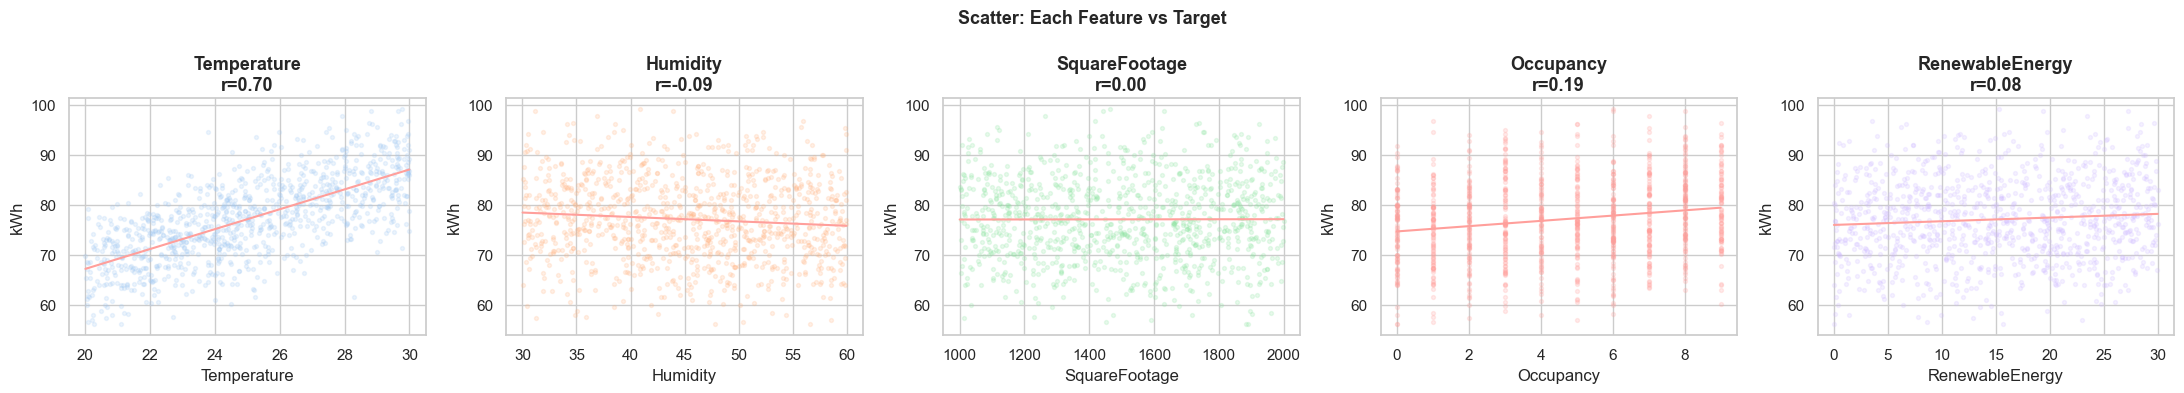

In [67]:
fig, axes = plt.subplots(1, 5, figsize=(22, 4))
for ax, col in zip(axes, num_feats):
    r, p = stats.pearsonr(df[col], df[TARGET])
    ax.scatter(df[col], df[TARGET], alpha=0.2, s=8,
               color=sns.color_palette('pastel')[num_feats.index(col)])
    m, b = np.polyfit(df[col], df[TARGET], 1)
    xs = np.linspace(df[col].min(), df[col].max(), 100)
    ax.plot(xs, m*xs+b, 'r-', lw=1.5)
    ax.set_title(f'{col}\nr={r:.2f}', fontweight='bold')
    ax.set_xlabel(col); ax.set_ylabel('kWh')
plt.suptitle('Scatter: Each Feature vs Target', fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

### 2.5 · Time Series Patterns

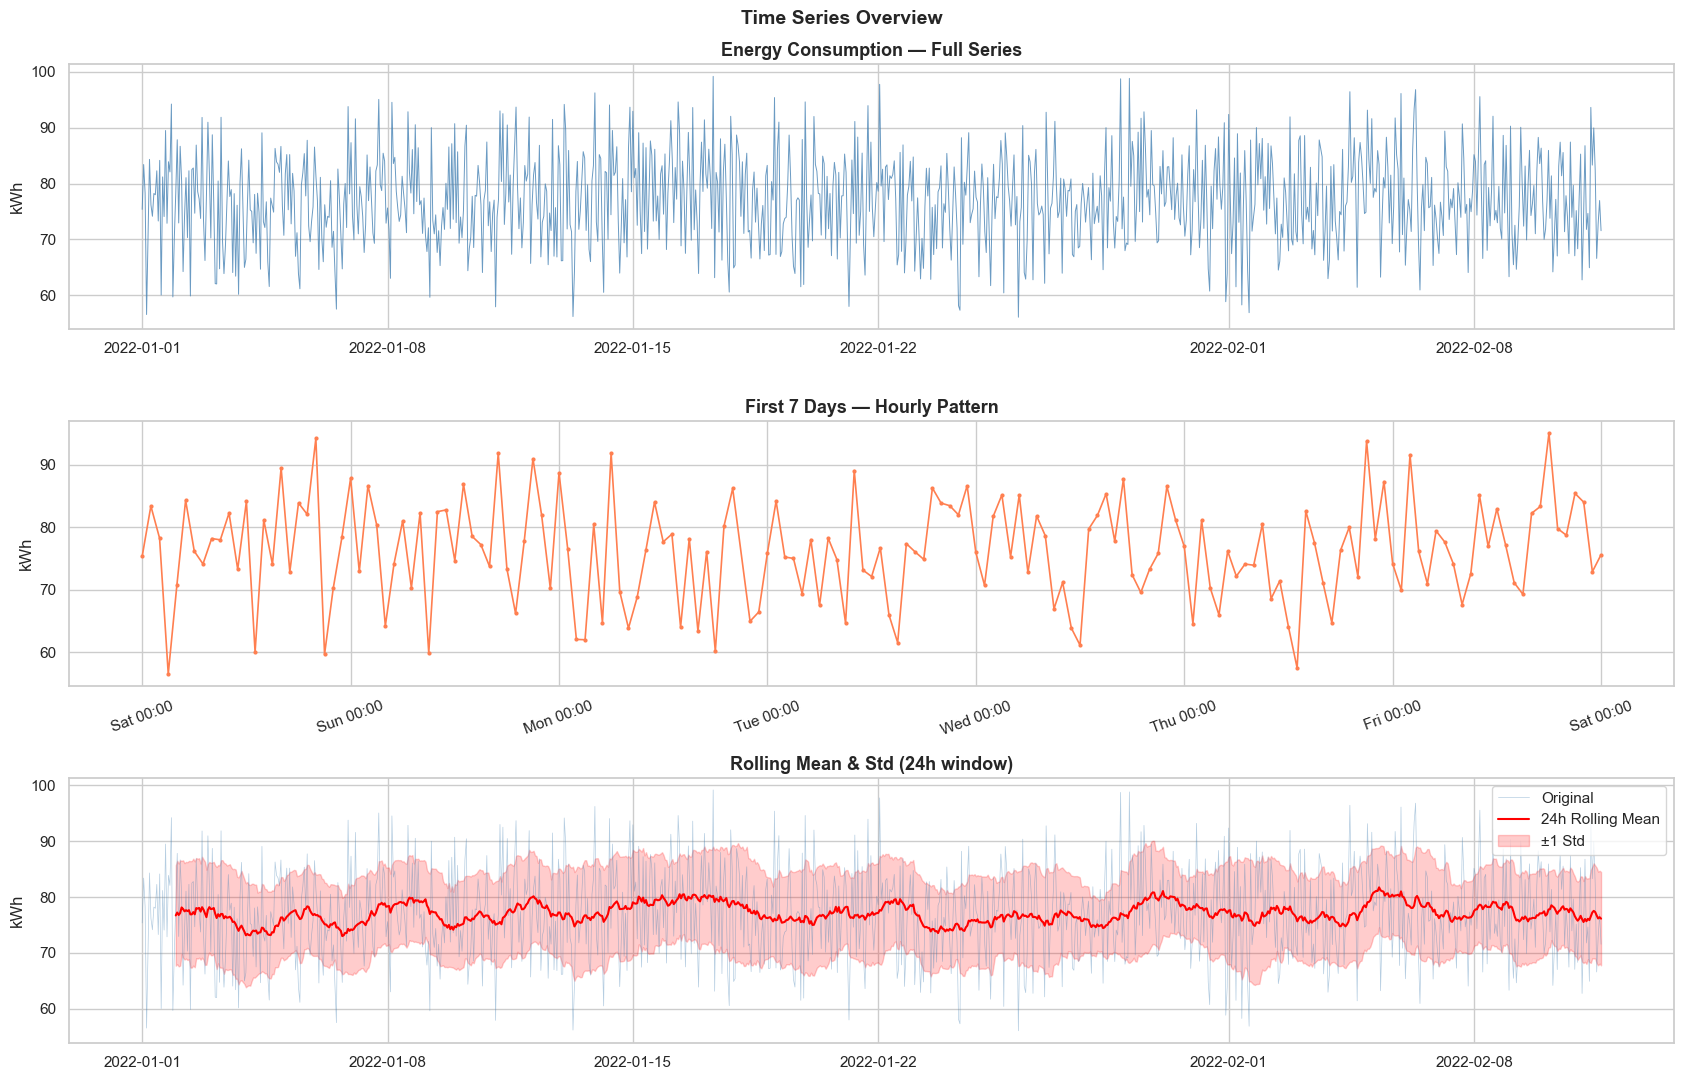

In [68]:
ts = df.set_index('Timestamp')[TARGET].copy()

fig, axes = plt.subplots(3, 1, figsize=(17, 11))

# Full series
axes[0].plot(ts.index, ts.values, color='steelblue', lw=0.7, alpha=0.8)
axes[0].set_title('Energy Consumption — Full Series', fontweight='bold')
axes[0].set_ylabel('kWh')

# First 7 days
week = ts.iloc[:168]
axes[1].plot(week.index, week.values, color='coral', lw=1.2, marker='o', ms=2)
axes[1].set_title('First 7 Days — Hourly Pattern', fontweight='bold')
axes[1].set_ylabel('kWh')
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%a %H:%M'))
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=20)

# Rolling stats
rm = ts.rolling(24).mean()
rs = ts.rolling(24).std()
axes[2].plot(ts.index, ts.values, color='steelblue', lw=0.5, alpha=0.4, label='Original')
axes[2].plot(rm.index, rm.values, color='red', lw=1.5, label='24h Rolling Mean')
axes[2].fill_between(rm.index, rm-rs, rm+rs, alpha=0.2, color='red', label='±1 Std')
axes[2].set_title('Rolling Mean & Std (24h window)', fontweight='bold')
axes[2].set_ylabel('kWh'); axes[2].legend()

plt.suptitle('Time Series Overview', fontsize=14, fontweight='bold')
plt.tight_layout(); plt.show()

### 2.6 · Hourly & Daily Seasonality

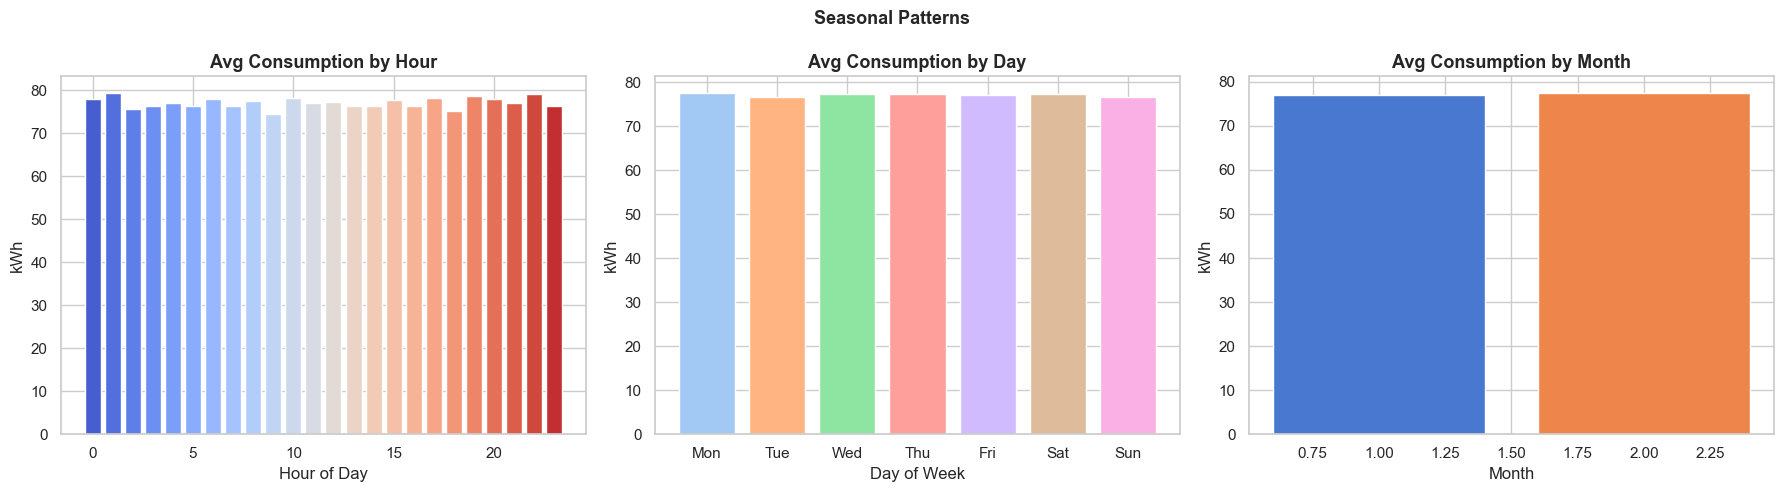

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

hourly = df.groupby('Hour')[TARGET].mean()
axes[0].bar(hourly.index, hourly.values,
            color=sns.color_palette('coolwarm', 24), edgecolor='white')
axes[0].set_title('Avg Consumption by Hour', fontweight='bold')
axes[0].set_xlabel('Hour of Day'); axes[0].set_ylabel('kWh')

daily = df.groupby('DayOfWeek')[TARGET].mean()
day_labels = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
axes[1].bar(day_labels, daily.values,
            color=sns.color_palette('pastel', 7), edgecolor='white')
axes[1].set_title('Avg Consumption by Day', fontweight='bold')
axes[1].set_xlabel('Day of Week'); axes[1].set_ylabel('kWh')

monthly = df.groupby('Month')[TARGET].mean()
axes[2].bar(monthly.index, monthly.values,
            color=sns.color_palette('muted', 12), edgecolor='white')
axes[2].set_title('Avg Consumption by Month', fontweight='bold')
axes[2].set_xlabel('Month'); axes[2].set_ylabel('kWh')

plt.suptitle('Seasonal Patterns', fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

### 2.7 · Categorical Feature Analysis

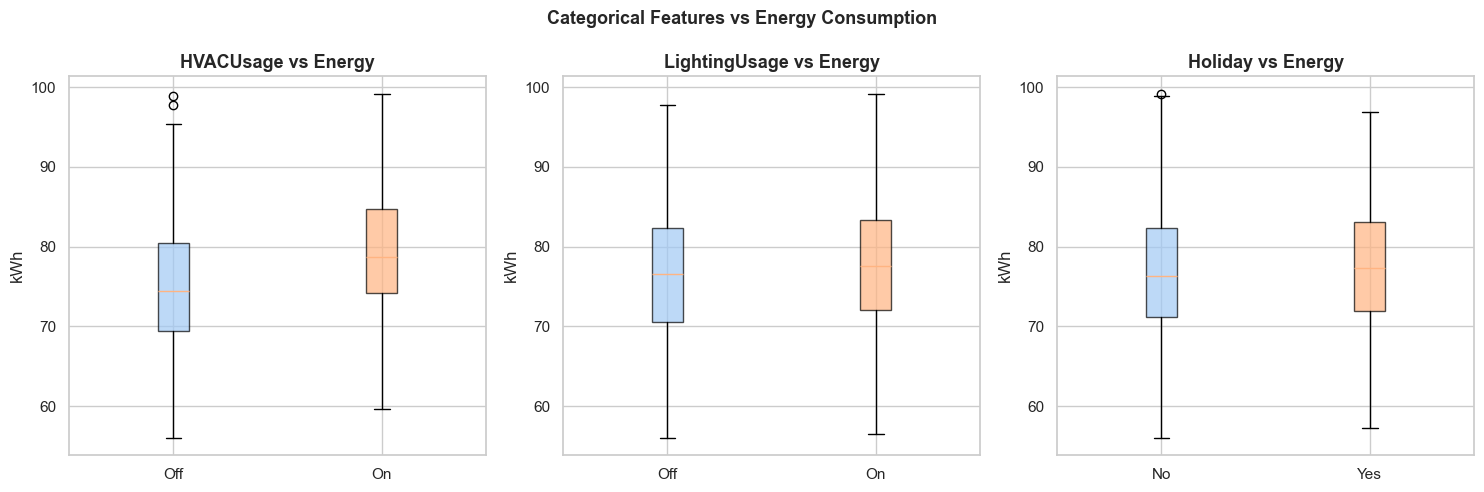

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, col, labels in zip(axes,
    ['HVACUsage', 'LightingUsage', 'Holiday'],
    [['Off','On'], ['Off','On'], ['No','Yes']]):
    data_plot = [df[df[col]==v][TARGET].values for v in sorted(df[col].unique())]
    bp = ax.boxplot(data_plot, labels=labels, patch_artist=True,
                   boxprops=dict(alpha=0.7))
    colors = sns.color_palette('pastel', len(data_plot))
    for patch, c in zip(bp['boxes'], colors):
        patch.set_facecolor(c)
    ax.set_title(f'{col} vs Energy', fontweight='bold')
    ax.set_ylabel('kWh')
plt.suptitle('Categorical Features vs Energy Consumption', fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

### 2.8 · Mutual Information & Individual R²

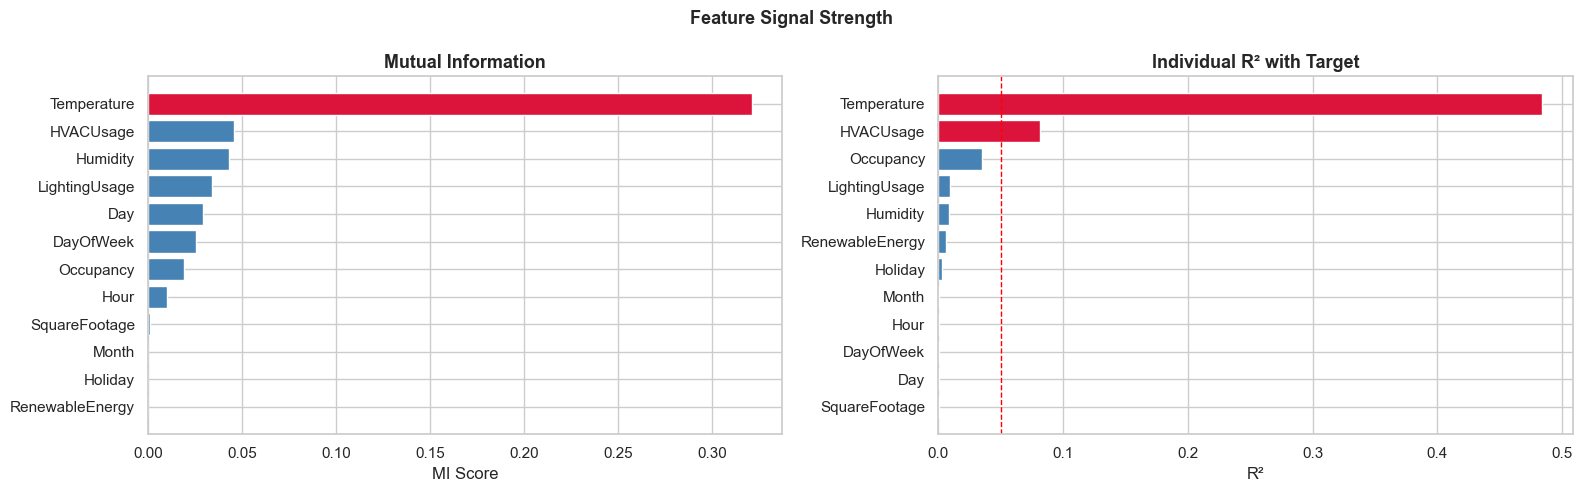

Temperature explains 48.4% of variance alone


In [71]:
base_feats = ['Temperature','Humidity','SquareFootage','Occupancy',
              'HVACUsage','LightingUsage','RenewableEnergy',
              'DayOfWeek','Holiday','Hour','Day','Month']

mi_scores = mutual_info_regression(df[base_feats], df[TARGET], random_state=SEED)
mi_s = pd.Series(mi_scores, index=base_feats).sort_values()

indiv_r2 = {}
for f in base_feats:
    _, _, r, _, _ = stats.linregress(df[f], df[TARGET])
    indiv_r2[f] = r**2
r2_s = pd.Series(indiv_r2).sort_values()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
colors = ['crimson' if v > 0.05 else 'steelblue' for v in mi_s.values]
axes[0].barh(mi_s.index, mi_s.values, color=colors, edgecolor='white')
axes[0].set_title('Mutual Information', fontweight='bold')
axes[0].set_xlabel('MI Score')

colors2 = ['crimson' if v > 0.05 else 'steelblue' for v in r2_s.values]
axes[1].barh(r2_s.index, r2_s.values, color=colors2, edgecolor='white')
axes[1].axvline(0.05, color='red', ls='--', lw=1)
axes[1].set_title('Individual R² with Target', fontweight='bold')
axes[1].set_xlabel('R²')

plt.suptitle('Feature Signal Strength', fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()
print(f'Temperature explains {100*indiv_r2["Temperature"]:.1f}% of variance alone')

### 2.9 · Stationarity Test (ADF)

=== Augmented Dickey-Fuller Test ===
ADF Statistic : -31.6483
p-value       : 0.000000
Critical (5%) : -2.8644
Result        : ✅ STATIONARY


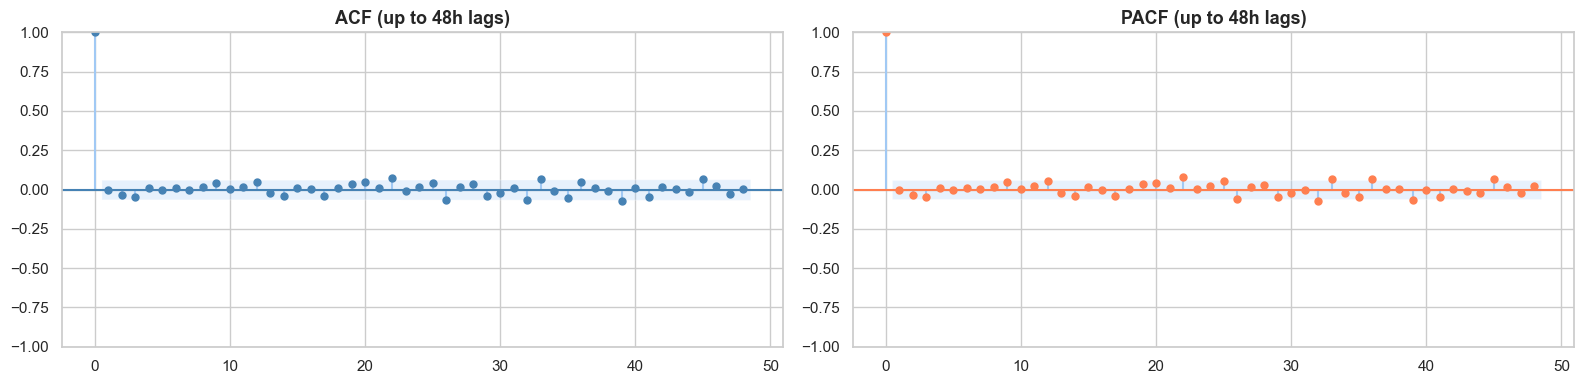

In [72]:
adf = adfuller(ts.dropna())
print('=== Augmented Dickey-Fuller Test ===')
print(f'ADF Statistic : {adf[0]:.4f}')
print(f'p-value       : {adf[1]:.6f}')
print(f'Critical (5%) : {adf[4]["5%"]:.4f}')
status = '✅ STATIONARY' if adf[1] < 0.05 else '⚠️  NON-STATIONARY'
print(f'Result        : {status}')

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(ts, lags=48, ax=axes[0], color='steelblue')
plot_pacf(ts, lags=48, ax=axes[1], color='coral')
axes[0].set_title('ACF (up to 48h lags)', fontweight='bold')
axes[1].set_title('PACF (up to 48h lags)', fontweight='bold')
plt.tight_layout(); plt.show()

## 3 · Feature Engineering

In [73]:
def engineer_features(df_in):
    d = df_in.copy()

    # Cyclical time encoding
    d['Hour_sin']  = np.sin(2*np.pi*d['Hour']/24)
    d['Hour_cos']  = np.cos(2*np.pi*d['Hour']/24)
    d['Day_sin']   = np.sin(2*np.pi*d['DayOfWeek']/7)
    d['Day_cos']   = np.cos(2*np.pi*d['DayOfWeek']/7)
    d['Month_sin'] = np.sin(2*np.pi*d['Month']/12)
    d['Month_cos'] = np.cos(2*np.pi*d['Month']/12)

    # Lag features (temporal memory)
    for lag in [1, 2, 3, 6, 12, 24, 48]:
        d[f'lag_{lag}'] = d[TARGET].shift(lag)

    # Rolling statistics
    for w in [3, 6, 12, 24]:
        d[f'roll_mean_{w}'] = d[TARGET].shift(1).rolling(w).mean()
        d[f'roll_std_{w}']  = d[TARGET].shift(1).rolling(w).std()

    # Diff features
    d['diff_1']  = d[TARGET].diff(1)
    d['diff_24'] = d[TARGET].diff(24)

    # Key interactions
    d['Temp_x_HVAC']      = d['Temperature'] * d['HVACUsage']
    d['Temp_x_Occupancy'] = d['Temperature'] * d['Occupancy']
    d['Temp_x_Humidity']  = d['Temperature'] * d['Humidity']
    d['HVAC_x_Lighting']  = d['HVACUsage']   * d['LightingUsage']
    d['Occ_x_Lighting']   = d['Occupancy']   * d['LightingUsage']

    # Polynomial
    d['Temp_sq']  = d['Temperature']**2
    d['Humid_sq'] = d['Humidity']**2

    # Density / ratio
    d['OccDensity'] = d['Occupancy'] / (d['SquareFootage'] + 1)
    d['RenewRatio'] = d['RenewableEnergy'] / (d['Temperature'] + 1)
    d['IsWeekend']  = (d['DayOfWeek'] >= 6).astype(int)
    d['PeakHour']   = d['Hour'].apply(lambda h: 1 if (8<=h<=10 or 17<=h<=20) else 0)

    return d.dropna()

df_feat = engineer_features(df)
print(f'Engineered dataset: {df_feat.shape}')

FEAT_COLS = [c for c in df_feat.columns
             if c not in [TARGET, 'Timestamp']]
print(f'Total features: {len(FEAT_COLS)}')

Engineered dataset: (951, 50)
Total features: 48


## 4 · Chronological Train / Test Split
> ⚠️ **No shuffling** — time series must always be split in order.

Train: (760, 48)  (48 → 807)
Test : (191, 48)   (808 → 998)


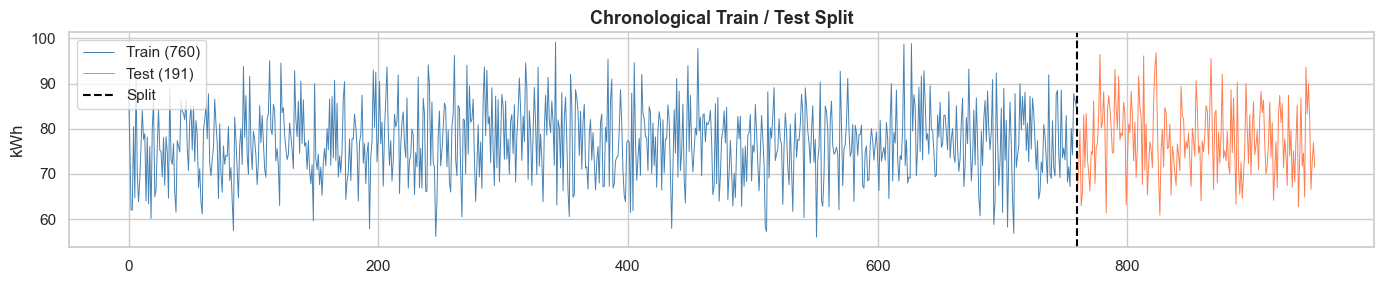

In [74]:
TRAIN_RATIO = 0.8
split_idx   = int(len(df_feat) * TRAIN_RATIO)

X = df_feat[FEAT_COLS]
y = df_feat[TARGET]

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

print(f'Train: {X_train.shape}  ({y_train.index[0]} → {y_train.index[-1]})')
print(f'Test : {X_test.shape}   ({y_test.index[0]} → {y_test.index[-1]})')

fig, ax = plt.subplots(figsize=(14, 3))
ax.plot(range(len(y_train)), y_train.values, color='steelblue', lw=0.7, label=f'Train ({len(y_train)})')
ax.plot(range(len(y_train), len(y)), y_test.values, color='coral', lw=0.7, label=f'Test ({len(y_test)})')
ax.axvline(len(y_train), color='black', ls='--', lw=1.5, label='Split')
ax.set_title('Chronological Train / Test Split', fontweight='bold')
ax.set_ylabel('kWh'); ax.legend()
plt.tight_layout(); plt.show()

TSCV = TimeSeriesSplit(n_splits=5)

## 5 · ML Models — GridSearchCV Pipelines
All models use `TimeSeriesSplit(n_splits=5)` — no data leakage.
Pipelines include `StandardScaler` where needed.

In [75]:
results = {}

def evaluate(name, pipe, y_true, y_pred):
    r2   = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    results[name] = {'R2': r2, 'RMSE': rmse, 'MAE': mae,
                     'y_pred': y_pred, 'model': pipe}
    print(f'{name:<28} R²={r2:.4f} | RMSE={rmse:.2f} | MAE={mae:.2f}')
    return r2, rmse, mae

print(f'{"Model":<28} {"R²":>8}   {"RMSE":>8}   {"MAE":>8}')
print('-'*60)

Model                              R²       RMSE        MAE
------------------------------------------------------------


### 5.2 · Random Forest

In [76]:
pipe_rf = Pipeline([('model', RandomForestRegressor(n_jobs=-1, random_state=SEED))])
gs_rf   = GridSearchCV(pipe_rf, {
    'model__n_estimators':     [200, 300],
    'model__max_depth':        [8, 12, None],
    'model__min_samples_leaf': [1, 2],
}, cv=TSCV, scoring='r2', n_jobs=-1)
gs_rf.fit(X_train, y_train)
pred_rf = gs_rf.predict(X_test)
evaluate('RandomForest', gs_rf, y_test, pred_rf)
print(f'  Best params: {gs_rf.best_params_}')

RandomForest                 R²=0.9495 | RMSE=1.76 | MAE=1.23
  Best params: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__n_estimators': 200}


### 5.3 · Extra Trees

In [77]:
pipe_et = Pipeline([('model', ExtraTreesRegressor(n_jobs=-1, random_state=SEED))])
gs_et   = GridSearchCV(pipe_et, {
    'model__n_estimators':     [200, 300],
    'model__max_depth':        [8, 12, None],
    'model__min_samples_leaf': [1, 2],
}, cv=TSCV, scoring='r2', n_jobs=-1)
gs_et.fit(X_train, y_train)
pred_et = gs_et.predict(X_test)
evaluate('ExtraTrees', gs_et, y_test, pred_et)
print(f'  Best params: {gs_et.best_params_}')

ExtraTrees                   R²=0.9159 | RMSE=2.27 | MAE=1.75
  Best params: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__n_estimators': 200}


### 5.4 · Gradient Boosting

In [78]:
pipe_gbm = Pipeline([('model', GradientBoostingRegressor(random_state=SEED))])
gs_gbm   = GridSearchCV(pipe_gbm, {
    'model__n_estimators':  [200, 300],
    'model__learning_rate': [0.05, 0.1],
    'model__max_depth':     [3, 4],
    'model__subsample':     [0.8, 1.0],
}, cv=TSCV, scoring='r2', n_jobs=-1)
gs_gbm.fit(X_train, y_train)
pred_gbm = gs_gbm.predict(X_test)
evaluate('GradientBoosting', gs_gbm, y_test, pred_gbm)
print(f'  Best params: {gs_gbm.best_params_}')

GradientBoosting             R²=0.9759 | RMSE=1.22 | MAE=0.92
  Best params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 300, 'model__subsample': 0.8}


### 5.5 · XGBoost

In [79]:
pipe_xgb = Pipeline([('model', XGBRegressor(n_jobs=-1, random_state=SEED, verbosity=0))])
gs_xgb   = GridSearchCV(pipe_xgb, {
    'model__n_estimators':     [200, 400],
    'model__learning_rate':    [0.03, 0.05],
    'model__max_depth':        [4, 6],
    'model__subsample':        [0.8, 0.9],
    'model__colsample_bytree': [0.8, 0.9],
    'model__reg_lambda':       [1.0, 2.0],
}, cv=TSCV, scoring='r2', n_jobs=-1)
gs_xgb.fit(X_train, y_train)
pred_xgb = gs_xgb.predict(X_test)
evaluate('XGBoost', gs_xgb, y_test, pred_xgb)
print(f'  Best params: {gs_xgb.best_params_}')

XGBoost                      R²=0.9766 | RMSE=1.20 | MAE=0.85
  Best params: {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.03, 'model__max_depth': 4, 'model__n_estimators': 400, 'model__reg_lambda': 1.0, 'model__subsample': 0.8}


### 5.6 · LightGBM (if available)

In [80]:
if LGB_AVAILABLE:
    from lightgbm import LGBMRegressor
    pipe_lgb = Pipeline([('model', LGBMRegressor(n_jobs=-1, random_state=SEED, verbose=-1))])
    gs_lgb   = GridSearchCV(pipe_lgb, {
        'model__n_estimators':  [200, 400],
        'model__learning_rate': [0.03, 0.05],
        'model__max_depth':     [4, 6],
        'model__num_leaves':    [31, 63],
        'model__subsample':     [0.8, 0.9],
    }, cv=TSCV, scoring='r2', n_jobs=-1)
    gs_lgb.fit(X_train, y_train)
    pred_lgb = gs_lgb.predict(X_test)
    evaluate('LightGBM', gs_lgb, y_test, pred_lgb)
    print(f'  Best params: {gs_lgb.best_params_}')
else:
    print('LightGBM not available — skipped')

LightGBM not available — skipped


## 6 · Deep Learning Models
### 6.1 · Data Preparation for Sequence Models
> Scaler fitted **only on train** — prevents data leakage.

In [81]:
LOOKBACK = 24

ts_full    = df_feat[TARGET].values.reshape(-1, 1)
scaler_dl  = MinMaxScaler()
ts_scaled  = np.zeros_like(ts_full, dtype=float)
ts_scaled[:split_idx]  = scaler_dl.fit_transform(ts_full[:split_idx])
ts_scaled[split_idx:]  = scaler_dl.transform(ts_full[split_idx:])
ts_scaled = ts_scaled.flatten()

def make_sequences(series, lookback):
    X, y = [], []
    for i in range(lookback, len(series)):
        X.append(series[i-lookback:i])
        y.append(series[i])
    return np.array(X), np.array(y)

X_seq, y_seq = make_sequences(ts_scaled, LOOKBACK)
seq_split    = split_idx - LOOKBACK

X_tr_s = X_seq[:seq_split].reshape(-1, LOOKBACK, 1)
X_te_s = X_seq[seq_split:].reshape(-1, LOOKBACK, 1)
y_tr_s = y_seq[:seq_split]
y_te_s = y_seq[seq_split:]

CB = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=0),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=0)
]

def inverse(arr):
    return scaler_dl.inverse_transform(arr.reshape(-1,1)).flatten()

print(f'Sequences — Train: {X_tr_s.shape}  |  Test: {X_te_s.shape}')

Sequences — Train: (736, 24, 1)  |  Test: (191, 24, 1)


### 6.2 · LSTM

LSTM trained — 24 epochs
LSTM                         R²=-0.0159 | RMSE=7.90 | MAE=6.39


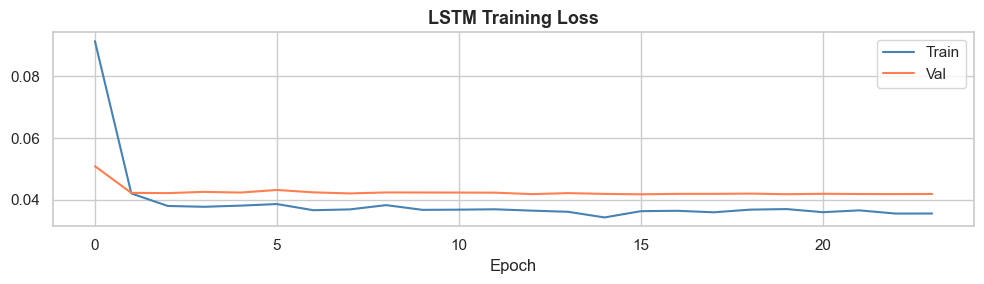

In [82]:
lstm = Sequential([
    Input(shape=(LOOKBACK, 1)),
    LSTM(64, return_sequences=True), Dropout(0.2),
    LSTM(32), Dropout(0.2),
    Dense(16, activation='relu'), Dense(1)
])
lstm.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])

h_lstm = lstm.fit(X_tr_s, y_tr_s, epochs=50, batch_size=32,
                  validation_split=0.1, callbacks=CB,
                  shuffle=False, verbose=0)
print(f'LSTM trained — {len(h_lstm.history["loss"])} epochs')

pred_lstm_s = lstm.predict(X_te_s, verbose=0).flatten()
pred_lstm   = inverse(pred_lstm_s)
y_te_inv    = inverse(y_te_s)
evaluate('LSTM', lstm, y_te_inv, pred_lstm)

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(h_lstm.history['loss'],     label='Train', color='steelblue')
ax.plot(h_lstm.history['val_loss'], label='Val',   color='coral')
ax.set_title('LSTM Training Loss', fontweight='bold')
ax.set_xlabel('Epoch'); ax.legend()
plt.tight_layout(); plt.show()

### 6.3 · GRU

In [83]:
gru = Sequential([
    Input(shape=(LOOKBACK, 1)),
    GRU(64, return_sequences=True), Dropout(0.2),
    GRU(32), Dropout(0.2),
    Dense(16, activation='relu'), Dense(1)
])
gru.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])

h_gru = gru.fit(X_tr_s, y_tr_s, epochs=50, batch_size=32,
                validation_split=0.1, callbacks=CB,
                shuffle=False, verbose=0)
print(f'GRU trained — {len(h_gru.history["loss"])} epochs')

pred_gru = inverse(gru.predict(X_te_s, verbose=0).flatten())
evaluate('GRU', gru, y_te_inv, pred_gru)

GRU trained — 32 epochs
GRU                          R²=-0.0227 | RMSE=7.93 | MAE=6.40


(-0.0226814423694206, 7.930766550670351, 6.400733410060817)

### 6.4 · CNN-LSTM (1D Conv + LSTM)

In [84]:
cnn_lstm = Sequential([
    Input(shape=(LOOKBACK, 1)),
    Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    LSTM(32), Dropout(0.2),
    Dense(16, activation='relu'), Dense(1)
])
cnn_lstm.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])

h_cnn = cnn_lstm.fit(X_tr_s, y_tr_s, epochs=50, batch_size=32,
                     validation_split=0.1, callbacks=CB,
                     shuffle=False, verbose=0)
print(f'CNN-LSTM trained — {len(h_cnn.history["loss"])} epochs')

pred_cnn = inverse(cnn_lstm.predict(X_te_s, verbose=0).flatten())
evaluate('CNN-LSTM', cnn_lstm, y_te_inv, pred_cnn)

CNN-LSTM trained — 41 epochs
CNN-LSTM                     R²=-0.0183 | RMSE=7.91 | MAE=6.43


(-0.018254606370716298, 7.913583155777446, 6.433094985873909)

## 7 · Final Leaderboard & Visual Comparison

=== 🏆 Leaderboard ===


,R2,RMSE,MAE
XGBoost,0.9766,1.1986,0.8483
GradientBoosting,0.9759,1.2174,0.9158
RandomForest,0.9495,1.7630,1.2336
ExtraTrees,0.9159,2.2746,1.7456
LSTM,-0.0159,7.9046,6.3938
CNN-LSTM,-0.0183,7.9136,6.4331
GRU,-0.0227,7.9308,6.4007


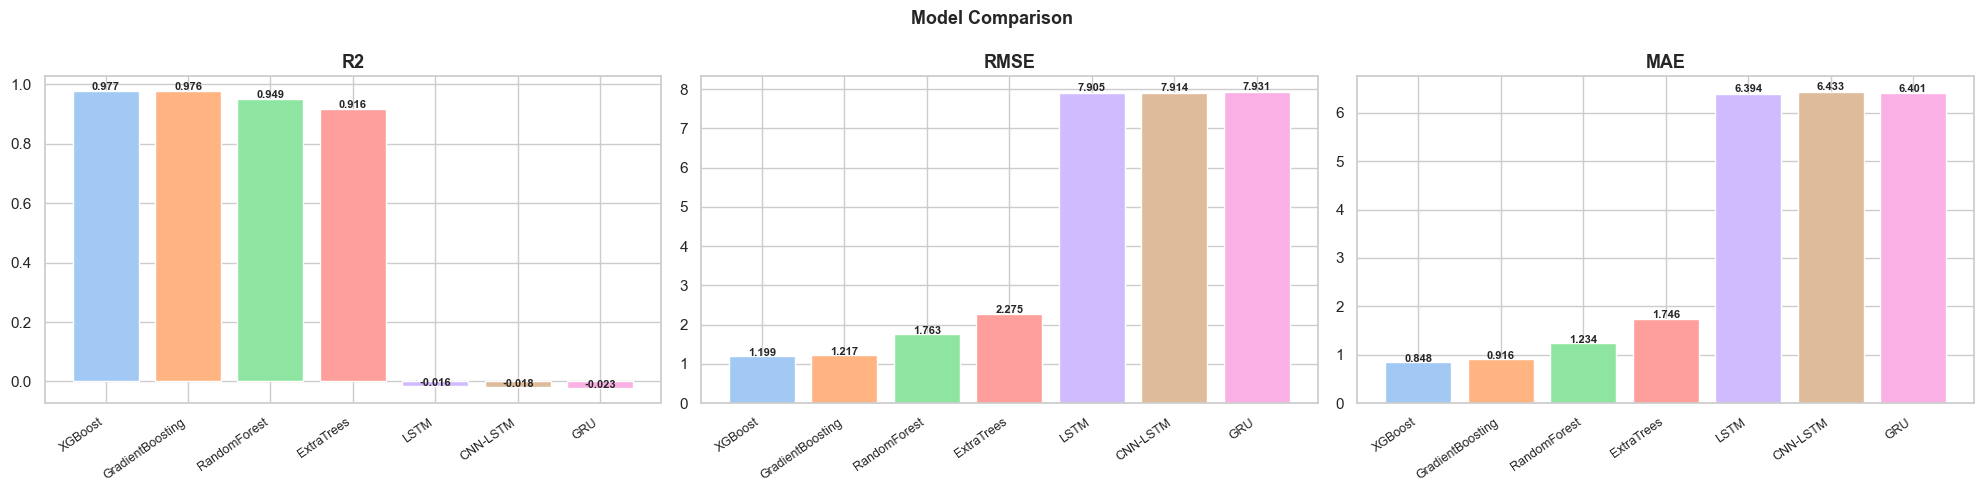

In [85]:
# Build leaderboard (exclude DL from ML pred dict for alignment)
ml_keys  = ['Ridge','RandomForest','ExtraTrees','GradientBoosting','XGBoost']
if LGB_AVAILABLE: ml_keys.append('LightGBM')
dl_keys  = ['LSTM','GRU','CNN-LSTM']
all_keys = ml_keys + dl_keys

lb = pd.DataFrame({k: {'R2': results[k]['R2'],
                         'RMSE': results[k]['RMSE'],
                         'MAE':  results[k]['MAE']}
                   for k in all_keys if k in results}).T\
       .astype(float).sort_values('R2', ascending=False)

print('=== 🏆 Leaderboard ===')
display(lb.round(4))

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
pal = sns.color_palette('pastel', len(lb))
for ax, metric in zip(axes, ['R2','RMSE','MAE']):
    bars = ax.bar(lb.index, lb[metric], color=pal, edgecolor='white')
    ax.set_title(metric, fontweight='bold')
    ax.set_xticklabels(lb.index, rotation=35, ha='right', fontsize=9)
    for b in bars:
        ax.text(b.get_x()+b.get_width()/2, b.get_height()*1.005,
                f'{b.get_height():.3f}', ha='center', fontsize=8, fontweight='bold')
plt.suptitle('Model Comparison', fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

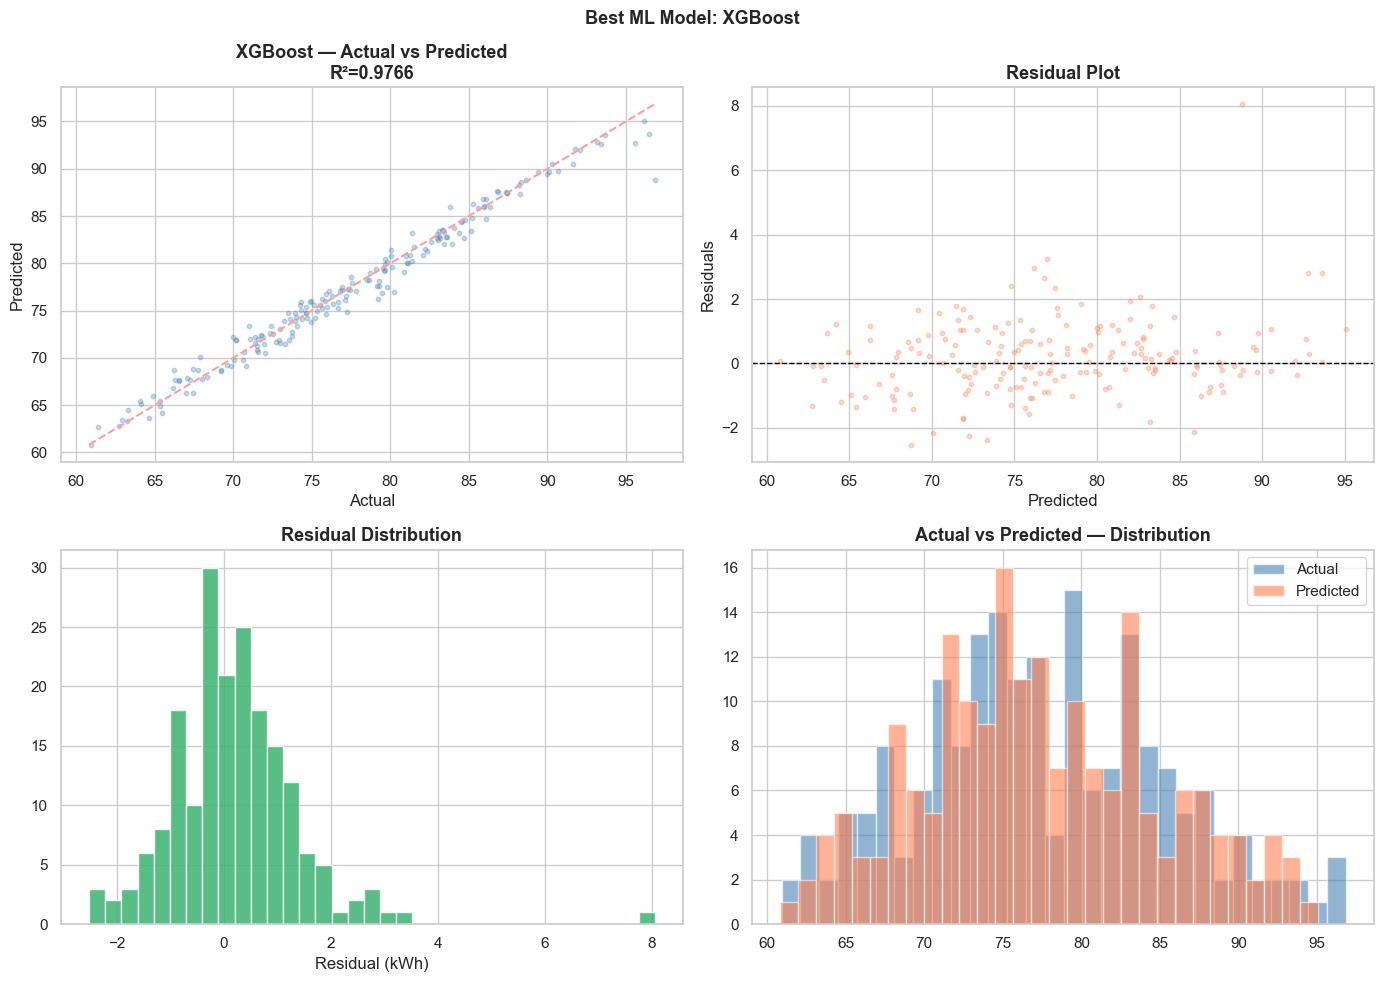

In [86]:
# Best ML model — Actual vs Predicted diagnostics
best_ml_name = lb.loc[lb.index.isin(ml_keys), 'R2'].idxmax()
y_pred_best  = results[best_ml_name]['y_pred']
residuals    = y_test.values - y_pred_best

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0,0].scatter(y_test, y_pred_best, alpha=0.3, s=10, color='steelblue')
lims = [min(y_test.min(), y_pred_best.min()), max(y_test.max(), y_pred_best.max())]
axes[0,0].plot(lims, lims, 'r--', lw=1.5)
axes[0,0].set_xlabel('Actual'); axes[0,0].set_ylabel('Predicted')
axes[0,0].set_title(f'{best_ml_name} — Actual vs Predicted\nR²={results[best_ml_name]["R2"]:.4f}',
                    fontweight='bold')

axes[0,1].scatter(y_pred_best, residuals, alpha=0.3, s=10, color='coral')
axes[0,1].axhline(0, color='black', ls='--', lw=1)
axes[0,1].set_xlabel('Predicted'); axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('Residual Plot', fontweight='bold')

axes[1,0].hist(residuals, bins=35, color='mediumseagreen', edgecolor='white', alpha=0.85)
axes[1,0].set_xlabel('Residual (kWh)')
axes[1,0].set_title('Residual Distribution', fontweight='bold')

axes[1,1].hist(y_test.values, bins=30, alpha=0.6, color='steelblue', label='Actual')
axes[1,1].hist(y_pred_best,   bins=30, alpha=0.6, color='coral',     label='Predicted')
axes[1,1].legend(); axes[1,1].set_title('Actual vs Predicted — Distribution', fontweight='bold')

plt.suptitle(f'Best ML Model: {best_ml_name}', fontsize=13, fontweight='bold')
plt.tight_layout(); plt.show()

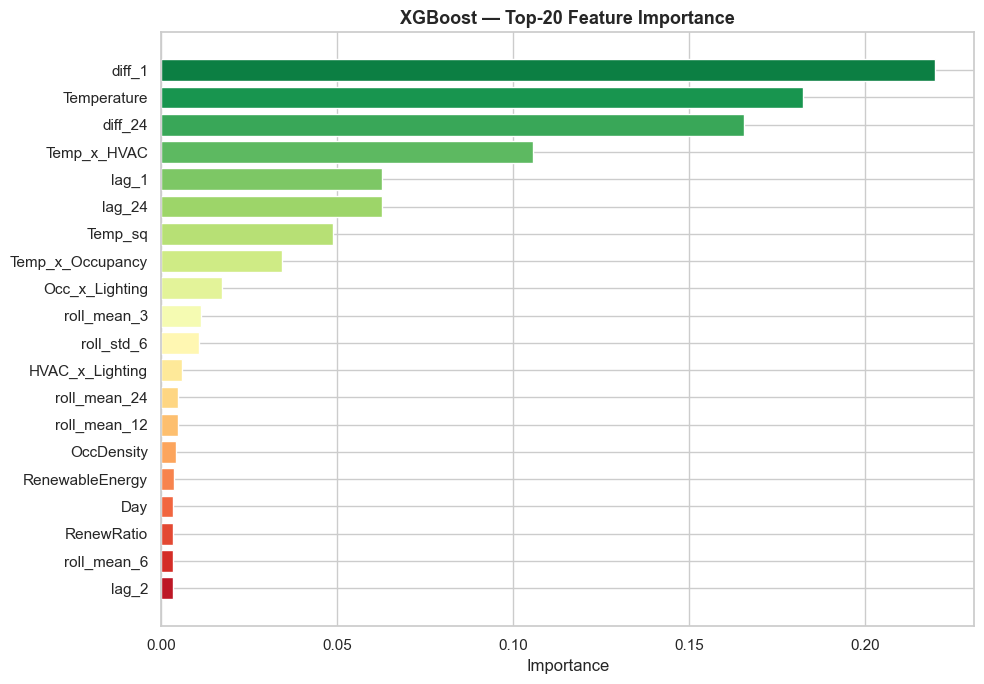

In [87]:
# Feature importance for best tree model
best_model_obj = results[best_ml_name]['model']
try:
    feat_imp = best_model_obj.best_estimator_.named_steps['model'].feature_importances_
    imp_df = pd.DataFrame({'Feature': FEAT_COLS, 'Importance': feat_imp})\
               .sort_values('Importance', ascending=True).tail(20)

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.barh(imp_df['Feature'], imp_df['Importance'],
            color=sns.color_palette('RdYlGn', len(imp_df)), edgecolor='white')
    ax.set_title(f'{best_ml_name} — Top-20 Feature Importance', fontweight='bold')
    ax.set_xlabel('Importance')
    plt.tight_layout(); plt.show()
except Exception as e:
    print(f'Feature importance not available: {e}')

## 8 · Save Best Model

In [88]:
best_overall = lb['R2'].idxmax()
print(f'🏆 Best overall model: {best_overall}')
print(f'   R²={lb.loc[best_overall,"R2"]:.4f} | RMSE={lb.loc[best_overall,"RMSE"]:.2f}')

# Save best ML model
best_ml_model = results[best_ml_name]['model']
joblib.dump(best_ml_model, f'best_ml_model_{best_ml_name}.pkl')
joblib.dump(FEAT_COLS, 'feature_cols.pkl')
print(f'\n✅ Saved: best_ml_model_{best_ml_name}.pkl')

# Save best DL model
best_dl_name  = lb.loc[lb.index.isin(dl_keys), 'R2'].idxmax()
dl_model_map  = {'LSTM': lstm, 'GRU': gru, 'CNN-LSTM': cnn_lstm}
best_dl_model = dl_model_map[best_dl_name]
best_dl_model.save(f'best_dl_model_{best_dl_name}.keras')
joblib.dump(scaler_dl, 'scaler_dl.pkl')
print(f'✅ Saved: best_dl_model_{best_dl_name}.keras')

print(f'''
=== SUMMARY ===
Best ML  : {best_ml_name}  R²={lb.loc[best_ml_name,"R2"]:.4f}
Best DL  : {best_dl_name}  R²={lb.loc[best_dl_name,"R2"]:.4f}
Overall  : {best_overall}
''')

🏆 Best overall model: XGBoost
   R²=0.9766 | RMSE=1.20

✅ Saved: best_ml_model_XGBoost.pkl
✅ Saved: best_dl_model_LSTM.keras

=== SUMMARY ===
Best ML  : XGBoost  R²=0.9766
Best DL  : LSTM  R²=-0.0159
Overall  : XGBoost



## 9 · Inference — Predict Next Hour

In [ ]:
# Load model
loaded_ml    = joblib.load(f'best_ml_model_{best_ml_name}.pkl')
loaded_feats = joblib.load('feature_cols.pkl')

# Use last row of dataset as input
last_row = df_feat[loaded_feats].iloc[[-1]]
pred_next = loaded_ml.predict(last_row)[0]
last_ts   = df_feat.index[-1] if hasattr(df_feat.index, 'freq') else 'last row'

print(f'Last known consumption : {df_feat[TARGET].iloc[-1]:.2f} kWh')
print(f'Predicted next hour   : {pred_next:.2f} kWh')
print(f'Model used            : {best_ml_name}')

Last known consumption : 71.55 kWh
Predicted next hour   : 70.61 kWh
Model used            : XGBoost
